Use python 3.10 in google colab

In [69]:
!wget https://github.com/korakot/kora/releases/download/v0.10/py310.sh
!bash ./py310.sh -b -f -p /usr/local
!python -m ipykernel install --name "py310" --user

'wget' is not recognized as an internal or external command,
operable program or batch file.
'bash' is not recognized as an internal or external command,
operable program or batch file.


Installed kernelspec py310 in C:\Users\William Hazen\AppData\Roaming\jupyter\kernels\py310


In [1]:
import copy

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from typing import Union
from torch.utils.data import Subset
import time
from tqdm import tqdm
from torchvision import transforms, models
from PIL import Image

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

c:\Users\David\anaconda3\envs\speaker-recon\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## SRC: datasets



In [2]:
import os
import torchaudio

def get_dataset(dataset_name, url = None, subset = None):
    """
    Retrieves a dataset and downloads it locally if needed.
        
    Inputs
    ------
    dataset_name : str
        Name of the dataset to download. Allowed dataset names: "librispeech", "librilightlimited", "tedlium"
    
    url : (str, optional)
        Optional argument for some datasets 
    
    subset : (str, optional)
        Optional argument for some datasets 
    
    Returns
    -------
    dataset :
        A torchaudio.dataset
    
    """
    _SAMPLE_DIR = "_assets"
    dataset_name = dataset_name.lower()
    dataset_path = os.path.join(_SAMPLE_DIR, dataset_name)
    os.makedirs(dataset_path, exist_ok=True)
        
    if dataset_name == "librispeech":
        url = url if url else "dev-clean"
        print(f"You're about to download librispeech with url {url}")
        dataset = torchaudio.datasets.LIBRISPEECH(dataset_path, download=True, url=url)
    
    elif dataset_name == "librilightlimited":
        subset = subset if subset else "10min"
        print(f"You're about to download librispeech with subset {subset}")
        dataset = torchaudio.datasets.LibriLightLimited(dataset_path, download=True, subset=subset)
        
    elif dataset_name == "tedlium":
        subset = subset if subset else "train"
        print(f"You're about to download Tedlium with subset {subset}")
        dataset = torchaudio.datasets.TEDLIUM(dataset_path, download=True, subset=subset)
    
    else:
        raise ValueError(f"The dataset you passed '{dataset_name}' is not in the list of datasets")
    
    print("\n Done downloading")
    return dataset 

## SRC: Visualization



In [3]:
#import os
from random import randint

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
#import torchaudio
from IPython.display import Audio, display


#Get a random video clip from dataset
def get_random_sample(dataset):
    """
    Takes a random sample in the dataset and return its waveform and sample rate
    """
    dataset_length = dataset.__len__()
    # get a random sample in the dataset
    sample_id = randint(0, dataset_length)
    (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = dataset.__getitem__(sample_id)
    
    return waveform, sample_rate
    
def plot_mfccs(waveform, sample_rate):
    wv_processed = waveform.numpy().flatten()
    mfccs = librosa.feature.mfcc(y=wv_processed, n_mfcc=13, sr=sample_rate)
    plt.figure(figsize=(15, 8))
    librosa.display.specshow(mfccs, x_axis="time", sr=sample_rate)
    #plt.colorbar(format="%+2.f")
    plt.show()
    
    
    
def play_audio(waveform : torch.Tensor, sample_rate : int) -> None:
    """
    Plays audio given a waveform and sample rate
    
    """
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")
        
def plot_specgram(waveform : torch.Tensor, sample_rate : int , title : str ="Spectrogram", xlim=None) -> None:
    """
    Plots a spectogram of audio given a waveform and sample rate
    """
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)
    
def plot_waveform(waveform, sample_rate, title = "Waveform", xlim = None, ylim = None):
    """
    Plots the waveform of an audio sample
    """
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
    if num_channels > 1:
        axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
        axes[c].set_xlim(xlim)
    if ylim:
        axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)
    
def visualize_random_sample(dataset, play_waveform = True, plot_wave = False, plot_spectogram = False):
    """
    Takes a random sample in the dataset and displays relevant metrics
    """
    dataset_length = dataset.__len__()
    # get a random sample in the dataset
    sample_id = randint(0, dataset_length)
    (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = dataset.__getitem__(sample_id)
    print('waveform: ', waveform)
    print('sample_rate: ', sample_rate)
    print('transcript: ', transcript)
    print('speaker_id: ', speaker_id)
    
    if play_waveform:
        play_audio(waveform, sample_rate)
        
    if plot_wave:
        plot_waveform(waveform, sample_rate)
    
    if plot_spectogram:
        plot_specgram(waveform, sample_rate, title=f"Sample {sample_id}, Speaker_id {speaker_id}")
        
def calculate_statistics(dataset) -> pd.DataFrame:
    """
    Calculates and plots statistics about the dataset
    
    Inputs
    ------
    dataset :
        The dataset to calculate statistics for
        
    verbose : bool
        If true, it will print the statistics
        
    Returns
    -------
    df_info : pd.DataFrame
        A dataframe with statistics about the dataset. Can be used to make your own statistics
    """
    print(f"Dataset has {dataset.__len__()} samples")
    print(f"Random samples has shape: {dataset.__getitem__(0)[0].shape}")
    
    waveform_lengths = []
    sample_rates = []
    transcript_lengths = []
    speaker_ids = []
    audio_durations = []    
    
    for i in range(dataset.__len__()):
        (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = dataset.__getitem__(i)
        waveform_lengths.append(waveform[0].shape[0])
        sample_rates.append(sample_rate)
        transcript_lengths.append(len(transcript))
        speaker_ids.append(speaker_id)
        
        num_channels, num_frames = waveform.shape
        duration = num_frames / sample_rate
        audio_durations.append(duration)
        
    dataset_stats = pd.DataFrame.from_dict(
    {
        "waveform_lengths" : waveform_lengths,
        "sample_rates" : sample_rates,
        "transcript_lengths" : transcript_lengths,
        "audio_durations" : audio_durations,
    }
    )
    
    print(f"Unique speaker ids: {len(np.unique(speaker_ids))}")
    display(dataset_stats.describe().loc[["min","std","min","max"]].round())
    print("\n")
    
    # plotting:
    fig, ax = plt.subplots(1, dataset_stats.shape[1], figsize=(12, 6))
    for i, col in enumerate(dataset_stats.columns):
        ax[i].boxplot(dataset_stats[col])
        ax[i].set_title(col)
    plt.tight_layout()
    
    plt.figure(figsize=(6, 6))
    plt.scatter(dataset_stats["waveform_lengths"], dataset_stats["transcript_lengths"])
    plt.xlabel("waveform_lengths")
    plt.ylabel("transcript_lengths")
    
    return dataset_stats

## SRC: Audio_utils





In [4]:
from typing import Union

import numpy as np
import numpy.typing as npt
import pandas as pd
from tqdm import tqdm


def split_waveform(waveform, window_size):
    """
    Takes an original waveform and reduce to chunks of smaller intervals using a sliding window
    
    waveform : nd.array
    
    window_size : int
        window size in seconds
    
    Returns
    -------
    splitted_waveform : list[nd.array]
        list of waveforms
    
    """
    splitted_waveform = []
    
    for i in range(0, len(waveform), window_size):
        split = waveform[i:i+window_size]
        if len(split) == window_size:
            splitted_waveform.append(split)

    return splitted_waveform

class CepstralNormalization:
    def __init__(self, number_spectral_coefficients : int):
        """
        Class for Cepstral Normalization. Cepstral normalization performs normalization
        by channels/coefficients
        """
        self.number_spectral_coefficients = number_spectral_coefficients
        self.mfcc_mean : list[float] = []
        self.mfcc_std : list[float] = []
    
    def fit(self, mfcc_ids, mfcc_channel_db):
        """
        Calculates the mean and standard deviation of each channel of the MFCCs
        
        Inputs
        ------
        mfcc_ids : list[int]
            list of the mfcc ids to use for fitting

        mfcc_channel_db : pd.DataFrame
            A dataframe of the following shape

                    channel_1 | channel 2 | channel 3 | ...
            mfcc_id

        Returns
        -------
        mfcc_mean : list[float]
            A list with the mean value of each channel
        
        mfcc_std : list[float]
            A list with the standard deviation value of each channel

        """
        mfcc_mean = []
        mfcc_std = []
        
        print('Normalizing...')
        for channel in tqdm(range(self.number_spectral_coefficients)):
            channel_data = mfcc_channel_db.loc[mfcc_ids][f"channel_{channel}"].values
            channel_data_list = []
            for x in channel_data:
                channel_data_list.extend(x.flatten().tolist())
            
            mfcc_mean.append(np.mean(channel_data_list))
            mfcc_std.append(np.std(channel_data_list))

        self.mfcc_mean, self.mfcc_std = mfcc_mean, mfcc_std
        
        return self.mfcc_mean, self.mfcc_std
    
    def transform(self, mfcc_ids, mfcc_channel_db):
        """
        Normalizes MFCCs

        Inputs
        ------
        mfcc_ids : list[int]
            list of the mfcc ids to normalize

        mfcc_channel_db : pd.DataFrame
            A dataframe of the following shape

                    channel_1 | channel 2 | channel 3 | ...
            mfcc_id

        Returns
        -------
        mfcc_channel_db : pd.DataFrame
            normalized dataframe

        """                
        normalized_mfcc_channel_db = pd.DataFrame(data=mfcc_ids, columns=['mfcc_id']).set_index('mfcc_id')

        for channel in range(self.number_spectral_coefficients):
            channel_data = mfcc_channel_db.loc[mfcc_ids][f"channel_{channel}"].values
            channel_data = (channel_data - self.mfcc_mean[channel]) / self.mfcc_std[channel]
            normalized_mfcc_channel_db[f"channel_{channel}"] = channel_data
            
        return normalized_mfcc_channel_db

    def inverse_transform(self):
        #TODO
        raise NotImplementedError

## Problem Definition: Speaker Classification

Our project consists of identifying a speaker based on recorded audio samples. The model is trained from multiple audio samples for many speakers. Given a new audio sample, the model should identify which of the speakers it belongs to.  

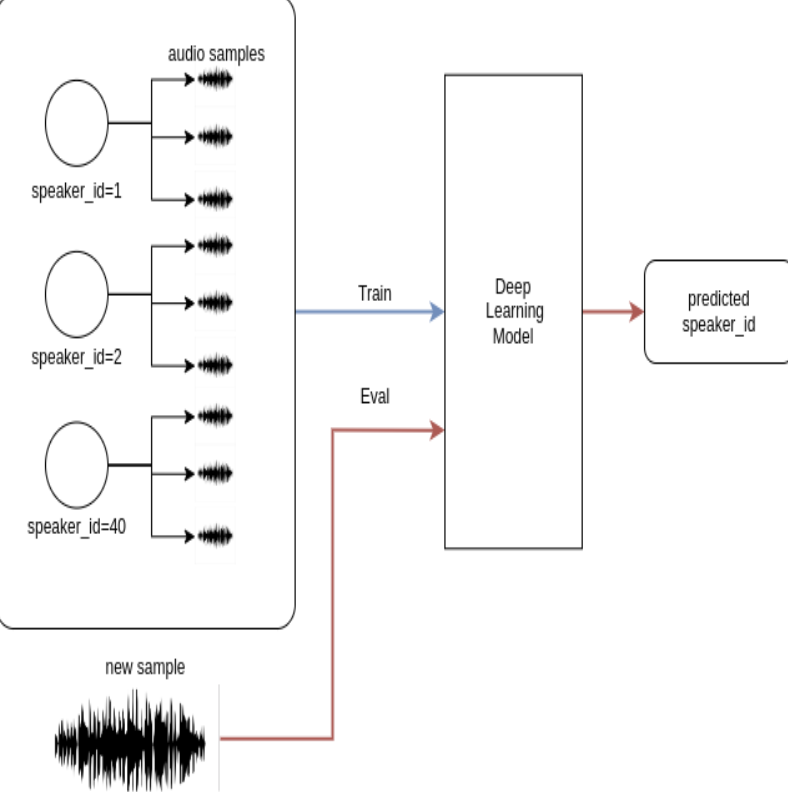

## Dataset
There are multiple datasets that include speaker_id and audio samples. Up to this point, we decided to start with Librispeech as it provides hours of recorded audio samples in relatively noise-free environments. 

LIBRISPEECH
LibriSpeech is a corpus of approximately 1000 hours of 16kHz read English speech, prepared by Vassil Panayotov with the assistance of Daniel Povey. The data is derived from read audiobooks from the LibriVox project, and has been carefully segmented and aligned.

There are multiple sizes of the dataset. In this notebook we are using **dev-clean** which is the development dataset. In other notebooks, we will use a version with more samples 

In [5]:
dataset_name = "librispeech"
url = 'train-clean-100'
dataset = get_dataset(dataset_name, url=url)

You're about to download librispeech with url train-clean-100

 Done downloading


# Data Visualization

The data extract from librispeech includes audio samples recorded as waveforms. In audio processing algorithm, it is standard practice to extract data by transforming the waveforms into a spectrogram or a varation of a spectrogram called a Mel-frequency cepstrum (MFC). This is done to remove unnecessary data from the waveforms and keep important information such as time, frequency, and amplitude.   

Visualizing data in random sample from the dataset

In [75]:
# visualize_random_sample(dataset, plot_wave=True, plot_spectogram=True)

#### Calculate statistics in dataset

In [76]:
# waveform_lengths = []
# sample_rates = []
# transcript_lengths = []
# speaker_ids = []
# audio_durations = []
# waveforms = []
# transcripts = []

# for i in tqdm(range(dataset.__len__())):
#     (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = dataset.__getitem__(i)
#     speaker_ids.append(speaker_id)

#     waveform_lengths.append(waveform[0].shape[0])
#     sample_rates.append(sample_rate)
#     transcript_lengths.append(len(transcript))
#     waveforms.append(waveform[0].numpy())
#     transcripts.append(transcript)
#     num_channels, num_frames = waveform.shape
#     duration = num_frames / sample_rate
#     audio_durations.append(duration)

# dataset_stats = pd.DataFrame.from_dict(
# {
#     "waveform_lengths" : waveform_lengths,
#     "sample_rates" : sample_rates,
#     "transcript_lengths" : transcript_lengths,
#     "audio_durations" : audio_durations,
# }
#     )

In [77]:
# df = calculate_statistics(dataset)

We can see from the above charts that there is a lot of variance in the audio duration. Our model needs to take consistent sizes of audio.

In [78]:
# df_spkr = pd.DataFrame(columns=['speaker_id', 'duration'])
# df_spkr['speaker_id'] = speaker_ids
# df_spkr['duration'] = audio_durations

In [13]:
#df_spkr.to_csv('df_speaker_ids.csv')
df_spkr = pd.read_csv('df_speaker_ids.csv')

In [80]:
# df_spkr.groupby('speaker_id').mean().sort_values(by='duration', ascending=True)

Because on average the duration of each speaker is 4.8 or higher, we decided to use a window_size of 4 seconds. Samples shorter than 4 seconds will be removed from the dataset.

Number of samples for each speaker

In [81]:
# df_spkr.groupby('speaker_id').size().sort_values()

We can see than in this dataset, some speakers have 36 samples only. This could potentially be little data to train a model. 

Unique speaker ids

In [82]:
# np.unique(df_spkr['speaker_id'])

Visualize spectrograms

In [83]:
# df_speaker_waveform = pd.DataFrame(columns=['speaker_id', 'waveform', 'transcript'])
# df_speaker_waveform['speaker_id'] = speaker_ids
# df_speaker_waveform['waveform'] = waveforms
# df_speaker_waveform['transcript'] = transcripts

In [84]:
# df_speaker_waveform[df_speaker_waveform['speaker_id']==84].head()

In [85]:
# num_cols = 3
# for speaker_id in np.unique(df_speaker_waveform['speaker_id'])[:8]:
#     fig, ax = plt.subplots(1, num_cols, figsize=(12, 3))
#     waves = df_speaker_waveform[df_speaker_waveform['speaker_id']==speaker_id]['waveform'].values
#     idx = df_speaker_waveform[df_speaker_waveform['speaker_id']==speaker_id]['waveform'].index
#     for j, wave in enumerate(waves[:num_cols]):
#         ax[j].specgram(wave, Fs=sample_rate)
#         ax[j].set_title(f'speaker {speaker_id}, df.index: {idx[j]}')

#         plt.tight_layout()

Visualize MFCC spectrograms

In [86]:
# num_cols = 3
# for speaker_id in np.unique(df_speaker_waveform['speaker_id'])[:8]:
#     fig, ax = plt.subplots(1, num_cols, figsize=(12, 3))
#     waves = df_speaker_waveform[df_speaker_waveform['speaker_id']==speaker_id]['waveform'].values
#     idx = df_speaker_waveform[df_speaker_waveform['speaker_id']==speaker_id]['waveform'].index
#     for j, wave in enumerate(waves[:num_cols]):
#         mfccs = librosa.feature.mfcc(y=wave.flatten(), n_mfcc=13, sr=sample_rate)
#         img = librosa.display.specshow(mfccs, x_axis="time", sr=sample_rate, ax=ax[j])
#         ax[j].set_title(f'speaker: {speaker_id}, df.index: {idx[j]}')
#         fig.colorbar(img, ax=ax[j], format="%+2.f dB")
#     plt.tight_layout()

Visualization of each channel in MFCC

In [87]:
# plt.figure(figsize=(12, 8))
# for i in range(mfccs.shape[0]):
#     plt.plot(mfccs[i,:], label=f"channel_{i}")
# plt.legend()

## Preprocessing

<center><img src="images/preprocessing.png" height="400"></center>

The preprocessing pipeline consists of the following steps:
1. Transform waveforms to MFCC
2. (optional) Perform Cepstral Normalization on the MFCC
3. Transform MFCC (2D-array) to a greyscale image

**Cepstral normalization** is the process of normalizing the MFCCs at every channel. The first channels of the MFCC carry the most important features; therefore, channels should not be mixed during normalization. At every channel, the values are normalized by subtracting the mean and dividing by the standard deviation: 
$$(X_{channel} - \mu_{channel})/\sigma_{channel} $$

Special consideration had to be taken during splitting of the data into train, validation, and test as well as during normalization. 

1. To ensure that each speaker_id is represent in each set, before splitting the audio samples were grouped by speaker id. Then the samples in each speaker_id are splitted in x% train, y% validation, z% test

2. To ensure there is no data leakage between training and other sets during normalization, **the Cepstral Normalizer only uses MFCCs from the training set during fitting.**

In [6]:
class MFCCData(Dataset):
    def __init__(self, speaker_mfcc_db, mfcc_channel_db, transform=None):
        """
        Creates a dataset of spectrograms from a dataset of waveforms
        
        Inputs
        ------
        speaker_mfcc_db : pd.DataFrame
            dataframe of (index, speaker_id, mfcc_id)
            
        mfcc_channel_db : pd.DataFrame
            dataframe of (mfcc_id, channel_1, channel_2, ...)
            
        transform : optional 
            transformations to perform on the MFCCs
        """
        self.speaker_mfcc_db = speaker_mfcc_db
        self.mfcc_channel_db = mfcc_channel_db        
        self.transform = transform
            
    def __len__(self):
        return len(self.speaker_mfcc_db)

    def __getitem__(self, idx):
        speaker_id = self.speaker_mfcc_db.iloc[idx]['speaker_id']
        mfcc_id = self.speaker_mfcc_db.iloc[idx]['mfcc_id']
        
        mfcc = []
        for i, col in enumerate(self.mfcc_channel_db.columns):
            mfcc_channel_i = self.mfcc_channel_db.loc[mfcc_id, f'channel_{i}']
            mfcc.append(mfcc_channel_i)
            
        mfcc = np.asarray(mfcc)
        mfcc = mfcc.reshape(len(self.mfcc_channel_db.columns), -1)
        
        if self.transform:
            mfcc = mfcc.reshape(1, mfcc.shape[0], mfcc.shape[1])
            mfcc = np.transpose(mfcc, [1, 2, 0])
            mfcc = self.transform(mfcc)
            
        else:
            mfcc = mfcc.reshape(1, mfcc.shape[0], mfcc.shape[1])
            
        speaker_id = torch.tensor(speaker_id) 
        mfcc = torch.tensor(mfcc) 
            
        if torch.cuda.is_available():
            speaker_id = speaker_id.to('cuda')
            mfcc = mfcc.to('cuda')
            
        return mfcc, speaker_id

In [7]:
def speaker_encoder(speaker_ids):
    """
    Creates a dictionary of (speaker_id, encoded_id) pairs
    """
    speaker_dict = {}
    for i, speaker_id in enumerate(speaker_ids):
        speaker_dict[speaker_id] = i
    return speaker_dict

In [8]:
def create_mfcc_databases(dataset, window_size, sample_rate, speaker_dict, number_spectral_coefficients):
    """
    Creates two databases from an audio dataset e.g. librispeech
    
    Inputs
    -----
    
    base_dataset : 
        A pytorch audio dataset like librispeech
    
    window_size : int
        window size to be used to consistently split waveforms

    sample_rate : int
        sample rate in kHz    
    
    speaker_dict : dict
        dictionary of {'speaker_id':encoded_id} pairs          

    number_spectral_coefficients : int
        number of spectral coefficients to keep for the MFCC calculation
        
    Returns
    -------
    speaker_mfcc_db : pd.DataFrame 
        df with shape (index_id, speaker_id, mfcc_id)
    
    mfcc_channel_db : pd.DataFrame
        df with shape (mfcc_id, channel_id)
    
    """
    try:
        speaker_mfcc_db = pd.read_pickle(f'speaker_mfcc_db_{window_size}_{sample_rate}_{number_spectral_coefficients}.pkl')
        mfcc_channel_db = pd.read_pickle(f'mfcc_channel_db_{window_size}_{sample_rate}_{number_spectral_coefficients}.pkl')
    
    except FileNotFoundError:
        speaker_mfcc_db = pd.DataFrame(columns=["speaker_id", "mfcc_id"])
        mfcc_channel_db = pd.DataFrame(columns=["mfcc_id"]+[f"channel_{i}" for i in range(number_spectral_coefficients)]).set_index('mfcc_id')

        idx = 0

        print('Creating a database. Hold tight...')
        for i in tqdm(range(dataset.__len__())):
            (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = dataset.__getitem__(i)
            waveform_arr = waveform.numpy().flatten()
            splitted_waveform = split_waveform(waveform_arr, window_size) # split waveforms into consistent chunks

            for chunk in splitted_waveform: # transform waveforms into MFCC spectrograms
                mfccs = librosa.feature.mfcc(y=chunk.flatten(), n_mfcc=13, sr=sample_rate)

                speaker_mfcc_db.loc[idx, "speaker_id"] = speaker_dict[speaker_id]
                speaker_mfcc_db.loc[idx, "mfcc_id"] = idx

                for j in range(number_spectral_coefficients):
                    mfcc_channel_db.loc[idx, f"channel_{j}"] = 1
                    mfcc_channel_db.at[idx, f"channel_{j}"] = mfccs[j, :]
                
                idx += 1

        speaker_mfcc_db.to_pickle(f'speaker_mfcc_db_{window_size}_{sample_rate}_{number_spectral_coefficients}.pkl')
        mfcc_channel_db.to_pickle(f'mfcc_channel_db_{window_size}_{sample_rate}_{number_spectral_coefficients}.pkl')

    return speaker_mfcc_db, mfcc_channel_db

In [9]:
def split_train_test_val(speaker_mfcc_db, train_pct, val_pct, 
                         test_pct):
    """
    Splits the dataset into train, validation, and test. This function returns the indices of the dataframe corresponding
    to each set
    """
    train_ids = []
    val_ids = []
    test_ids = []
    
    for speaker_id in np.unique(speaker_mfcc_db["speaker_id"].values):
        mfcc_ids = speaker_mfcc_db[speaker_mfcc_db["speaker_id"]==speaker_id]["mfcc_id"].sample(frac=1).tolist()
        len_ids = len(mfcc_ids)
        
        train_ids.extend(mfcc_ids[:int(len_ids * train_pct)])
        val_ids.extend(mfcc_ids[int(len_ids * train_pct):int(len_ids * (train_pct + val_pct))])
        test_ids.extend(mfcc_ids[int(len_ids * (train_pct + val_pct)):])
    
    return train_ids, val_ids, test_ids

In [14]:
def get_datasets(base_dataset, speaker_dict, window_size, sample_rate , train_pct , 
                 val_pct , test_pct , number_spectral_coefficients , cepstral_normalize , 
                 transform=None):
    """
    Wrapper around other functions to create datasets
    
    Inputs
    -----
    
    base_dataset : 
        A pytorch audio dataset like librispeech
    
    speaker_dict : dict
        dictionary of {'speaker_id':encoded_id} pairs          

    window_size : int
        window size to be used to consistently split waveforms

    sample_rate : int
        sample rate in kHz

    train_pct : float
        train percentage
    
    val_pct : float
        validation percentage

    test_pct : float
        Test percentage

    number_spectral_coefficients : int
        number of spectral coefficients to keep for the MFCC calculation
        
    normalize : bool
        whether to apply cepstral normalization
        
    transform : 
        a custom transformation to apply to the dataset
        
    Returns
    -------
    
    mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test
    
    """
    speaker_mfcc_db, mfcc_channel_db = create_mfcc_databases(base_dataset, window_size=window_size, sample_rate=sample_rate, speaker_dict=speaker_dict, number_spectral_coefficients=number_spectral_coefficients)

    train_ids, val_ids, test_ids = split_train_test_val(speaker_mfcc_db, train_pct, val_pct, test_pct)
    
    speaker_mfcc_db_train = speaker_mfcc_db.loc[train_ids]
    speaker_mfcc_db_val = speaker_mfcc_db.loc[val_ids]
    speaker_mfcc_db_test = speaker_mfcc_db.loc[test_ids]
    
    if cepstral_normalize:
        cepstral_normalization = CepstralNormalization(number_spectral_coefficients)
        cepstral_normalization.fit(speaker_mfcc_db_train['mfcc_id'].values, mfcc_channel_db)
        normalized_mfcc_channel_db_train = cepstral_normalization.transform(speaker_mfcc_db_train['mfcc_id'].values, mfcc_channel_db)
        normalized_mfcc_channel_db_val = cepstral_normalization.transform(speaker_mfcc_db_val['mfcc_id'].values, mfcc_channel_db)
        normalized_mfcc_channel_db_test = cepstral_normalization.transform(speaker_mfcc_db_test['mfcc_id'].values, mfcc_channel_db)
        mfcc_channel_db = pd.concat([normalized_mfcc_channel_db_train, normalized_mfcc_channel_db_val, normalized_mfcc_channel_db_test])
        
    mfcc_channel_db_train = mfcc_channel_db.loc[speaker_mfcc_db_train['mfcc_id'].values]
    mfcc_channel_db_val = mfcc_channel_db.loc[speaker_mfcc_db_val['mfcc_id'].values]
    mfcc_channel_db_test = mfcc_channel_db.loc[speaker_mfcc_db_test['mfcc_id'].values]
    
    mfcc_dataset_train = MFCCData(speaker_mfcc_db_train, mfcc_channel_db_train, transform=transform)
    mfcc_dataset_val = MFCCData(speaker_mfcc_db_val, mfcc_channel_db_val, transform=transform)
    mfcc_dataset_test = MFCCData(speaker_mfcc_db_test, mfcc_channel_db_test, transform=transform)

    return mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test

In [11]:
# preprocessing parameters
sample_rate = 16000 # 16kHz
window_size = 4 * sample_rate # 1 second has 16000 samples, window_size is 4 seconds

batch_size = 10

train_pct = 0.60
val_pct = 0.20
test_pct = 0.20
number_spectral_coefficients = 13
cepstral_normalize = True

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(size=(224, 224))]) 

In [15]:
speaker_dict = speaker_encoder(np.unique(df_spkr['speaker_id']))
mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test = get_datasets(dataset, 
                                                speaker_dict=speaker_dict,
                                                window_size=window_size, 
                                                sample_rate=sample_rate, 
                                                train_pct=train_pct,
                                                val_pct=val_pct,
                                                test_pct=test_pct,
                                                number_spectral_coefficients=number_spectral_coefficients,
                                                cepstral_normalize=cepstral_normalize,
                                                transform=transform,
                                                )

Normalizing...


100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


In [95]:
# import pickle
# with open(r'C:\Users\William Hazen\Documents\UofT\Term 1 (F)\MIE 1517\MIE 1517 Projects\audio-speaker-recognition\mfcc_dataset_train.pkl', 'rb') as f:
#     mfcc_dataset_train = pickle.load(f)

# with open(r'C:\Users\William Hazen\Documents\UofT\Term 1 (F)\MIE 1517\MIE 1517 Projects\audio-speaker-recognition\mfcc_dataset_val.pkl', 'rb') as f:
#     mfcc_dataset_val = pickle.load(f)
    
# with open(r'C:\Users\William Hazen\Documents\UofT\Term 1 (F)\MIE 1517\MIE 1517 Projects\audio-speaker-recognition\mfcc_dataset_test.pkl', 'rb') as f:
#     mfcc_dataset_test = pickle.load(f)

In [28]:
train_set = Subset(mfcc_dataset_train, range(0, mfcc_dataset_train.__len__(), 10))
val_set = Subset(mfcc_dataset_val, range(0, mfcc_dataset_val.__len__(), 10))

In [16]:
train_loader = DataLoader(mfcc_dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(mfcc_dataset_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mfcc_dataset_test, batch_size=batch_size, shuffle=False)

In [17]:
mfcc_dataset_train.__len__(), mfcc_dataset_val.__len__(), mfcc_dataset_test.__len__(), 

(44653, 14917, 15020)

In [18]:
train_loader.__len__(), val_loader.__len__()

(4466, 1492)

In [100]:
# for a, b in train_loader:
#     break
# print(a.shape)

In [101]:
# plt.imshow(np.transpose(a[0].to('cpu').numpy(), [1, 2, 0]))

Visualize a random sample from the dataloader to verify it looks as expected

In [102]:
# random_sample = np.random.randint(0, 2300)
# sample_mfcc, sample_speaker = mfcc_dataset_train.__getitem__(random_sample)

# print(sample_mfcc.shape, sample_speaker.shape)

# mfcc_arr = sample_mfcc.to('cpu').numpy().reshape(224, 224)
# plt.figure()
# plt.imshow(mfcc_arr)
# plt.figure(figsize=(12, 8))
# for i in range(mfcc_arr.shape[0]):
#     plt.plot(mfcc_arr[i,:], label=f"channel_{i}")
# plt.legend()

## Model Training

In [103]:
def evaluate(model, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_epoch = 0
    val_acc = []

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            mfcc, speakers = data
            outputs = model(mfcc)

            loss = criterion(outputs, speakers)
            total_loss += loss.item()
            total_epoch += len(speakers)
            val_acc.append(get_accuracy(model, loader))

        loss = float(total_loss) / (i + 1)
        val_acc = np.mean(val_acc)
    return loss, val_acc

def get_accuracy(model, dataloader):
    #select index with maximum prediction score
    correct = 0
    total = 0
    for data in dataloader:
        mfcc, labels = data
        output = model(mfcc)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

def train_model(model, train_loader, val_loader, batch_size, num_epochs, criterion, optimizer, print_every=2, plot_loss=True):
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
        
    if torch.cuda.is_available():
        model = model.to(torch.device('cuda:0'))
    
    for epoch in tqdm(range(num_epochs)): 
        total_train_loss = 0.0
        total_epoch = 0
        total_train_acc = []
        correct = 0.0
        total = 0.0
        
        model.train()
        
        for i, data in enumerate(train_loader):
            mfcc, speakers = data
                        
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass, backward pass, and optimize
            outputs = model(mfcc)
            loss = criterion(outputs, speakers)
            loss.backward()
            optimizer.step()
            
            # Calculate the statistics
            total_train_loss += loss.item()
            total_epoch += len(speakers)
            total_train_acc.append(get_accuracy(model, train_loader))
            
        model.eval()
        train_loss[epoch] = float(total_train_loss) / (i+1)
        train_acc[epoch] = np.mean(total_train_acc)        
        val_loss[epoch], val_acc[epoch] = evaluate(model, val_loader, criterion)
        
        if epoch % print_every == 0:    
            print(f"Epoch {epoch}: \n \
            Train loss {train_loss[epoch]:.3f} | Val loss {val_loss[epoch]:.3f} \n \
            Train acc {train_acc[epoch]:.3f} | Val acc {val_acc[epoch]:.3f} \n")
            
            
    if plot_loss:
        n = len(train_loss) # number of epochs
        plt.figure()
        plt.title("Train vs Validation Loss")
        plt.plot(range(1,n+1), train_loss, label="Train")
        plt.plot(range(1,n+1), val_loss, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend(loc='best')

        plt.figure()
        plt.title("Train vs Validation Accuracy")
        plt.plot(range(1,n+1), train_acc, label="Train")
        plt.plot(range(1,n+1), val_acc, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend(loc='best')   

In [104]:
class FCN(nn.Module):
    def __init__(self, input_layers, hidden_layers, output_size):
        super(FCN, self).__init__()

        self.fc1 = nn.Linear(3 * 11 * 124, hidden_layers)
        self.fc2 = nn.Linear(hidden_layers, output_size)

    def forward(self, x):
        x = x.float()
        x = x.view(-1, 13 * 126)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [105]:
class CNN(nn.Module):
    def __init__(self, hidden_layers, output_size):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(1 * 224 * 224, hidden_layers)
        self.fc2 = nn.Linear(hidden_layers, output_size)

    def forward(self, x):
        x = x.float()
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = x.view(-1, 1 * 224 * 224)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [106]:
# model hyperparameters
hidden_layers = 300
output_size = len(np.unique(df_spkr['speaker_id']))
lr = 0.01
momentum = 0.9
num_epochs = 30

model = CNN(hidden_layers=hidden_layers, output_size=output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)#, momentum=momentum)
num_epochs = num_epochs

In [107]:
# # CNN model 1
# train_model(model, train_loader, val_loader, batch_size, num_epochs, criterion, optimizer, print_every=1)

In [108]:
# # CNN 2

# # model hyperparameters
# hidden_layers = 500
# output_size = len(np.unique(df_spkr['speaker_id']))
# lr = 0.05
# momentum = 0.9
# num_epochs = 30

# model = CNN(hidden_layers=hidden_layers, output_size=output_size)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)#, momentum=momentum)
# num_epochs = num_epochs

# train_model(model, train_loader, val_loader, batch_size, num_epochs, criterion, optimizer, print_every=1)

In [109]:
# # CNN 3

# # model hyperparameters
# hidden_layers = 150
# output_size = len(np.unique(df_spkr['speaker_id']))
# lr = 0.01
# momentum = 0.9
# num_epochs = 20

# model = CNN(hidden_layers=hidden_layers, output_size=output_size)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)#, momentum=momentum)
# num_epochs = num_epochs

# train_model(model, train_loader, val_loader, batch_size, num_epochs, criterion, optimizer, print_every=1)

Note: the test model and the test dataset will be side aside to the end of the project, to evaluate the overall accuracy of the best model. Therefore, the team will not use the test model or test dataset for the progress report. 

In [110]:
# def test_model(model, test_loader):
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for data in test_loader:
#             mfcc, speakers = data
#             outputs = model(mfcc)
#             _, predicted = torch.max(outputs.data, 1)
#             total += speakers.size(0)
#             correct += (predicted == speakers).sum().item()

#     print(f'Accuracy: {100 * correct // total} %')

In [111]:
# test_model(model, test_loader)

In [112]:
# speaker_dict # {original_speaker_id, encoded_speaker_id}

In [113]:
# classes = [str(speaker_id) for speaker_id in range(len(np.unique(df_spkr['speaker_id'])))]
# correct_pred = {classname: 0 for classname in classes}
# total_pred = {classname: 0 for classname in classes}

# for mfcc, speakers in test_loader:
#     outputs = model(mfcc)
#     _, predicted = torch.max(outputs.data, 1)
#     # print(f"predicted: {predicted}, actual: {speakers}")
#     for label, prediction in zip(speakers, predicted):
#             if label == prediction:
#                 correct_pred[classes[label]] += 1
#             total_pred[classes[label]] += 1
    
# for classname, correct_count in correct_pred.items():
#     accuracy = 100 * float(correct_count) / total_pred[classname]
#     print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

## AlexNet

In [114]:
alexnet = models.alexnet(pretrained=False)

c:\Users\William Hazen\anaconda3\envs\speech_recon_venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\William Hazen\anaconda3\envs\speech_recon_venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [115]:
# Freeze model parameters
for param in alexnet.parameters():
    param.requires_grad = False

In [116]:
alexnet.features[0] = nn.Conv2d(1, 64, kernel_size=(1,1))

In [117]:
#Modify the final output layer
alexnet.classifier.add_module("6",nn.Linear(4096, 500))
alexnet.classifier.add_module("7",nn.LeakyReLU())
alexnet.classifier.add_module("8",nn.Linear(500, len(np.unique(df_spkr['speaker_id']))))
# alexnet.classifier.add_module("9", nn.LogSoftmax(dim = 1))
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inpla

In [19]:
subset_train_size, subset_val_size = train_loader.__len__(), val_loader.__len__()

In [20]:
print(subset_train_size)
print(subset_val_size)

4466
1492


In [21]:
# Define Optimizer and Loss Function

def train_and_validate(model, epochs=25, batch_size = 10, lr=1e-3):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0
    loss_criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)
                
                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/subset_train_size 
        avg_train_acc = train_acc/subset_train_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/subset_val_size 
        avg_valid_acc = valid_acc/subset_val_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        #torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history

In [121]:
alexnet = alexnet.to('cuda')

AssertionError: Torch not compiled with CUDA enabled

In [122]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


trained_model, history = train_and_validate(alexnet, epochs=25, batch_size = 64, lr=1e-3)

Epoch: 1/25


C:\Users\William Hazen\AppData\Local\Temp\ipykernel_6868\1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


KeyboardInterrupt: 

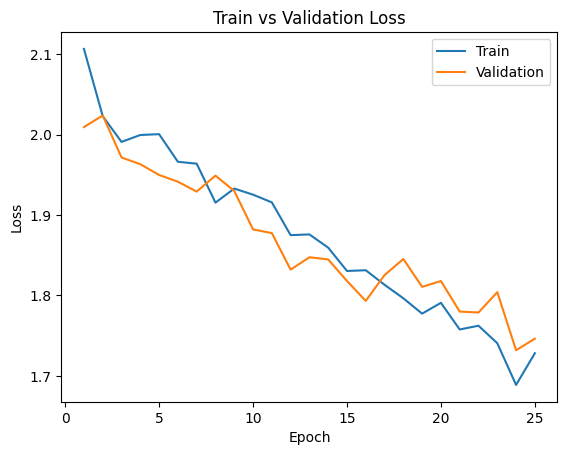

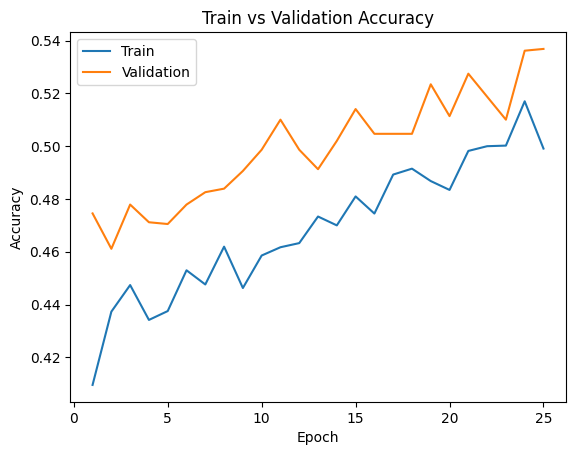

In [ ]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []
ep = []
i = 0
for tloss,vloss, tacc, vacc in history:
    train_acc.append(tacc)
    val_acc.append(vacc)
    train_loss.append(tloss)
    val_loss.append(vloss)
    ep.append(i)
    i += 1


n = len(train_loss) # number of epochs
plt.figure()
plt.title("Train vs Validation Loss")
plt.plot(range(1,n+1), train_loss, label="Train")
plt.plot(range(1,n+1), val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
# plt.show()

plt.figure()
plt.title("Train vs Validation Accuracy")
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')

In [ ]:
#TODO: Ran alexnet 3 times for the report [WILL]

AlexNet #2:
Single FC output layer with Softmax activation function

In [26]:
alexnet2 = models.alexnet(pretrained=False)
# Freeze model parameters
#for param in alexnet2.parameters():
#    param.requires_grad = False
#Modify the model structure
# Input layer to 1 channel for one channel img    
alexnet2.features[0] = nn.Conv2d(1, 64, kernel_size=(1,1))
#Modify the final output layer
alexnet2.classifier.add_module("6",nn.Linear(4096, len(np.unique(df_spkr['speaker_id']))))
alexnet2.classifier.add_module("7", nn.LogSoftmax(dim = 1))
alexnet2

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inpla

In [29]:
alexnet2 = alexnet2.to('cuda')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


trained_model, history = train_and_validate(alexnet2, epochs=55, batch_size = 64, lr=1e-4)

Epoch: 1/55


C:\Users\David\AppData\Local\Temp\ipykernel_8320\1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


Epoch : 001, Training: Loss: 5.5273, Accuracy: 0.2911%, 
		Validation : Loss : 5.5231, Accuracy: 0.7373%, Time: 26.7232s
Epoch: 2/55


KeyboardInterrupt: 

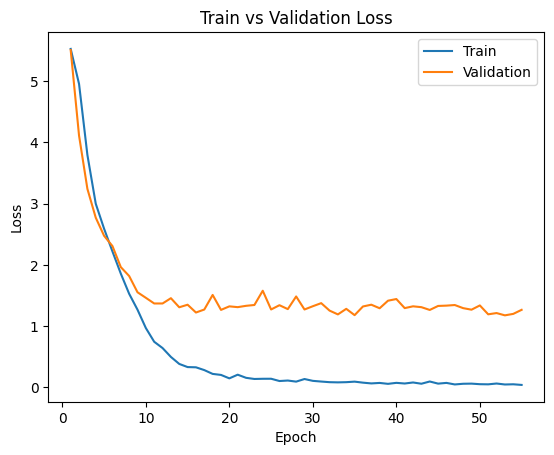

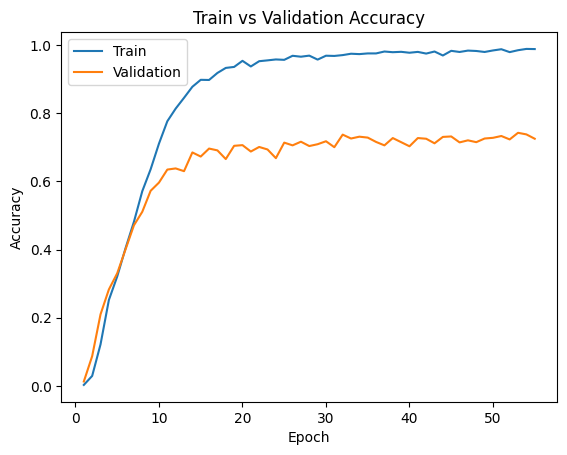

In [ ]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []
ep = []
i = 0
for tloss,vloss, tacc, vacc in history:
    train_acc.append(tacc)
    val_acc.append(vacc)
    train_loss.append(tloss)
    val_loss.append(vloss)
    ep.append(i)
    i += 1


n = len(train_loss) # number of epochs
plt.figure()
plt.title("Train vs Validation Loss")
plt.plot(range(1,n+1), train_loss, label="Train")
plt.plot(range(1,n+1), val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
# plt.show()

plt.figure()
plt.title("Train vs Validation Accuracy")
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')

AlexNet #3: ReLU activation function between last two FC layers and Softmax at end

In [19]:
alexnet3 = models.alexnet(pretrained=False)
# Freeze model parameters
#for param in alexnet3.parameters():
#    param.requires_grad = False
#Modify the model structure
# Input layer to 1 channel for one channel img    
alexnet3.features[0] = nn.Conv2d(1, 64, kernel_size=(1,1))

#Modify the final output layer
alexnet3.classifier.add_module("6",nn.Linear(4096, 2048))
alexnet3.classifier.add_module("7",nn.ReLU())
alexnet3.classifier.add_module("8",nn.Linear(2048, len(np.unique(df_spkr['speaker_id']))))
alexnet3.classifier.add_module("9", nn.LogSoftmax(dim = 1))
alexnet3

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inpla

In [ ]:
alexnet3 = alexnet3.to('cuda')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


trained_model, history = train_and_validate(alexnet3, epochs=35, batch_size = 64, lr=1e-4)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

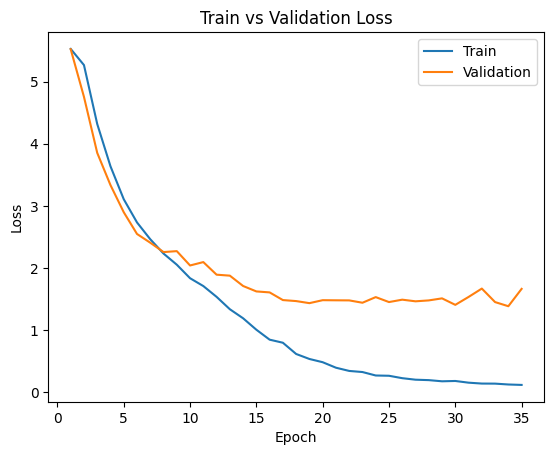

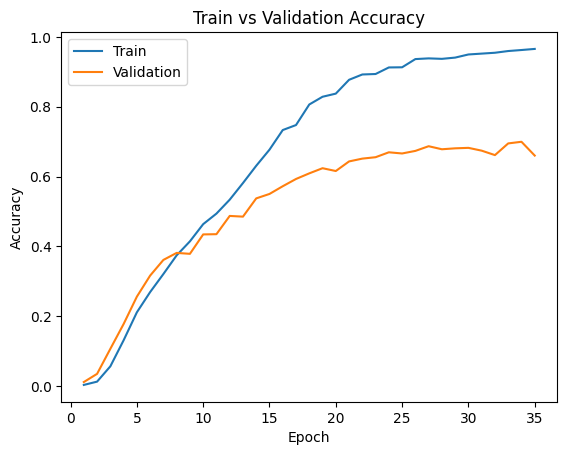

In [ ]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []
ep = []
i = 0
for tloss,vloss, tacc, vacc in history:
    train_acc.append(tacc)
    val_acc.append(vacc)
    train_loss.append(tloss)
    val_loss.append(vloss)
    ep.append(i)
    i += 1


n = len(train_loss) # number of epochs
plt.figure()
plt.title("Train vs Validation Loss")
plt.plot(range(1,n+1), train_loss, label="Train")
plt.plot(range(1,n+1), val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
# plt.show()

plt.figure()
plt.title("Train vs Validation Accuracy")
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')

## Hyperparameter Tuning

Create a function that given a model (YeNet) and a configuration space (LR, batchsize, etc) it will return the configuration that optimizes validation loss or accuracy

#### Training function

In [23]:
# Define Optimizer and Loss Function

def HP_training(model, params):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    
    lr = params["learning_rate"]
    batch_size = params["batch_size"]
    epochs = 30
    
    history = []
    best_acc = 0.0
    loss_criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_loader = DataLoader(mfcc_dataset_train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(mfcc_dataset_val, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        best_loss = np.inf
        
        for i, (inputs, labels) in enumerate(train_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)
                
                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)
                
                if valid_loss < best_loss:
                    best_loss = valid_loss
                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/subset_train_size 
        avg_train_acc = train_acc/subset_train_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/subset_val_size 
        avg_valid_acc = valid_acc/subset_val_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Validation Loss: {:.4f}, Train Loss: {:.4f}%, \n\t \Val Accuracy: {:.4f}, Training Accuracy: {:.4f}%, Time: {:.4f}s"
              .format(epoch+1, avg_valid_loss, avg_train_loss, avg_valid_acc*100, avg_train_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        #torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return best_loss

#### Hyperparameter Tuning

Create a function that given a model (YeNet) and a configuration space (LR, batchsize, etc) it will return the configuration that optimizes validation loss or accuracy

In [24]:
import optuna

In [31]:
alexnet4 = models.alexnet(pretrained=False)
# Freeze model parameters
#for param in alexnet3.parameters():
#    param.requires_grad = False
#Modify the model structure
# Input layer to 1 channel for one channel img    
alexnet4.features[0] = nn.Conv2d(1, 64, kernel_size=(1,1))

#Modify the final output layer
alexnet4.classifier.add_module("6",nn.Linear(4096, 2048))
alexnet4.classifier.add_module("7",nn.ReLU())
alexnet4.classifier.add_module("8",nn.Linear(2048, len(np.unique(df_spkr['speaker_id']))))
alexnet4.classifier.add_module("9", nn.LogSoftmax(dim = 1))

c:\Users\David\anaconda3\envs\speaker-recon\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\David\anaconda3\envs\speaker-recon\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [30]:
def HP_Tune(trial):
    #trained_model, history = train_and_validate(alexnet3, epochs=35, batch_size = 64, lr=1e-4)
    params = {
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),
        "batch_size": trial.suggest_int("batch_size", 10, 64)
    }
    all_losses = []
    temp_loss = HP_training(alexnet4, params)
    #_,_, temp_loss = HP_training(model, params)

    all_losses.append(temp_loss)
    
    return np.mean(all_losses)

In [33]:
scr_list = []
#alexnet_list = [ alexnet2, alexnet3]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
alexnet4 = alexnet4.to('cuda')
study = optuna.create_study(direction="minimize")
study.optimize(HP_Tune, n_trials = 10)

print("Best Trial:")
trial_ = study.best_trial
print(trial_.values)
print(trial_.params)


print("Currently training on:", alexnet4)
SCR = HP_training(alexnet4, trial_.params)
scr_list.append(SCR)
print(SCR)

[I 2022-11-27 10:23:20,913] A new study created in memory with name: no-name-098b10fb-00d0-4e57-9df3-f572b14fd0d8
C:\Users\David\AppData\Local\Temp\ipykernel_8320\3463528286.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),
C:\Users\David\AppData\Local\Temp\ipykernel_8320\1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


Epoch: 1/30
Epoch : 001, Validation Loss: 22.6161, Train Loss: 34.4874%, 
	 \Val Accuracy: 384.5845, Training Accuracy: 154.3215%, Time: 238.0217s
Epoch: 2/30


[W 2022-11-27 10:27:36,019] Trial 0 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "C:\Users\David\AppData\Roaming\Python\Python310\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\David\AppData\Local\Temp\ipykernel_8320\3463528286.py", line 8, in HP_Tune
    temp_loss = HP_training(alexnet4, params)
  File "C:\Users\David\AppData\Local\Temp\ipykernel_8320\3691409089.py", line 67, in HP_training
    train_loss += loss.item() * inputs.size(0)
KeyboardInterrupt


KeyboardInterrupt: 

# FUTURE WORK
- Based on the current best accuracy, the team will re-validate the models with more datasets (other than librispeech)
- The team will implement automated hyper prameter tuning on the current best model to see if the accuracy will be acceptable. 
- If the accuracy is low, the team will try other architectures
- The team will set up a meeting with the professor or the TAs to get some feedback. 